# Wavelet-regularized potential reconstruction

__last update__: 25/11/21

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
from astropy.io import fits
from matplotlib.colors import LogNorm, TwoSlopeNorm
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util

## Global settings

In [2]:
# Save figures on disk?
SAVE_FIGURES = False
SAVE_MODELS = True

# Type of the potential perturbations that we seek to recover
perturbation_type = 'GRF' # supported choices: 'dark_halo', 'GRF', 'discyness', 'boxyness'

# Whether or not a fully-smooth fit of the data should be performed 
fit_fully_smooth_first = False
start_from_fully_smooth = False
wavelet_regularization = True

# Factor of pixel scale for the potential grid
potential_pixel_scale = 4

# Choice of seeing conditions
psf_type = 'gaussian'  # 'gaussian', 'HST'
# Warning: 'HST' will take more time as convolutions are performed in real space... for now.

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=2e-2, flux_vmax=2e0, res_vmax=4)

## Simulate the mock data

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_grid = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_grid)
pixel_grid_fit = deepcopy(pixel_grid)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Seeing & instrumental effects

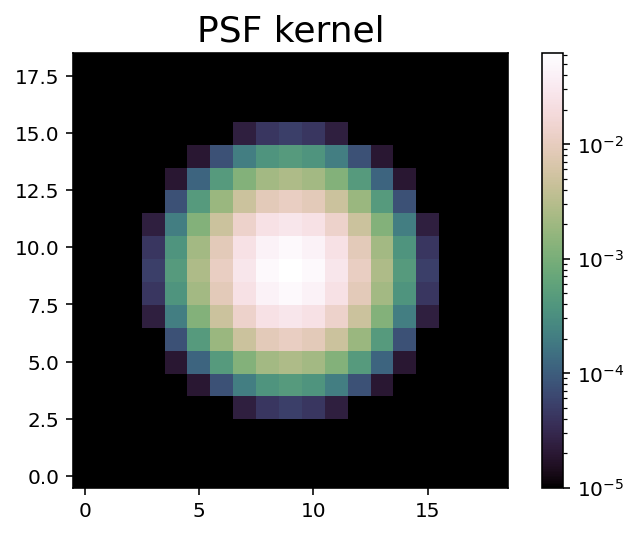

In [4]:
# PSF
if psf_type == 'gaussian':
    # Gaussian PSF
    psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
    convolution_type = None  # ignored when using gaussian PSF (blurring performed through fast gaussian filtering)
elif psf_type == 'HST':
    # PSF from HST F160W
    psf_kernel = fits.getdata(os.path.join('data', 'PSF_HST_F160W_tinytim.fits'), header=False)
    psf_kernel = psf_kernel[25:-25, 25:-25] # trim it a bit so convolutions are faster
    psf_kernel /= psf_kernel.sum()
    print(psf_kernel.shape, psf_kernel.sum())
    psf = PSF(psf_type='PIXEL', kernel_point_source=psf_kernel)
    convolution_type = 'grid'
plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

# Noise
exp_time = 2000
sigma_bkd = 0.01
noise = Noise(npix, npix, background_rms=sigma_bkd, exposure_time=exp_time)
noise_fit = deepcopy(noise)

### Mass and light models

Input shear strength: 0.032 & direction: 54.217
Input macro axis ratio: 0.731 & direction: -7.466


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


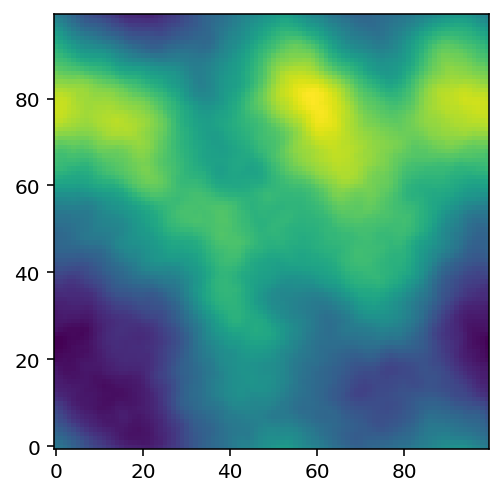

In [5]:
# Input lens mass model 
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_ext_shear_input['gamma1'], kwargs_ext_shear_input['gamma2'])
print(f"Input shear strength: {gamma_ext:.3f} & direction: {phi_ext*180/np.pi:.3f}")
phi, q = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
print(f"Input macro axis ratio: {q:.3f} & direction: {phi*180/np.pi:.3f}")

# Input potential perturbations
if perturbation_type == 'dark_halo':
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'SIE'])
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'theta_E': 0.12, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}
    ]
    
elif perturbation_type in ['discyness', 'boxyness']:
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'MULTIPOLE'])
    phi_macro_lens, _ = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
    if perturbation_type == 'discyness':
        phi_shift = 0
    elif perturbation_type == 'boxyness':
        phi_shift = 45*np.pi/180.
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'m': 4, 'a_m': 0.2, 'phi_m': phi_macro_lens + phi_shift, 'center_x': 0.0, 'center_y': 0.0}
    ]
    
elif perturbation_type == 'GRF':
    logA = -3.8
    beta = -5
    phase = 42
    box_length = 2 * np.pi * npix * pix_scl
    pb = pbox.PowerBox(N=npix, dim=2, pk=(lambda k: 10**logA * k**beta), boxlength=box_length, seed=phase)
    psi_grid_input = pb.delta_x()
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'PIXELATED'])
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'pixels': psi_grid_input},
    ]
    plt.figure()
    plt.imshow(psi_grid_input, origin='lower')
    plt.show()

# Fitted lens mass model
kwargs_pixelated_lens = {'pixel_scale_factor': potential_pixel_scale}
lens_mass_model_fit = LensModel(['SIE', 'SHEAR', 'PIXELATED'],
                                kwargs_pixelated=kwargs_pixelated_lens)

# Input source model 
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]

# Input lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 30.0, 'R_sersic': 2., 'n_sersic': 2., 
     'e1': kwargs_macro_lens_input['e1'], 'e2': kwargs_macro_lens_input['e2'], 
     'center_x': kwargs_macro_lens_input['center_x'], 'center_y': kwargs_macro_lens_input['center_y']}
]

### Image model classes, for both simulate and fit

In [6]:
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': convolution_type}

# True image model
lens_image_input = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_input,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

# Hybrid image model for fitting
lens_image_fit = LensImage(pixel_grid_fit, psf, noise_class=noise_fit,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

In [7]:
# Extract coordinate grids for pixelated potential
x_grid_fit, y_grid_fit = lens_image_fit.Grid.model_pixel_coordinates('lens')

# Extract the true perturbation potential on original and low-res grids
psi_grid_input = lens_image_input.LensModel.potential(x_grid, y_grid, kwargs_lens_input, k=-1)
psi_grid_input_fitgrid = lens_image_input.LensModel.potential(x_grid_fit, y_grid_fit, kwargs_lens_input, k=-1)

# this is then the 'true' input parameters for the smooth+pixelated model
kwargs_lens_input_interp = [kwargs_lens_input[0], {'pixels': psi_grid_input_fitgrid}]

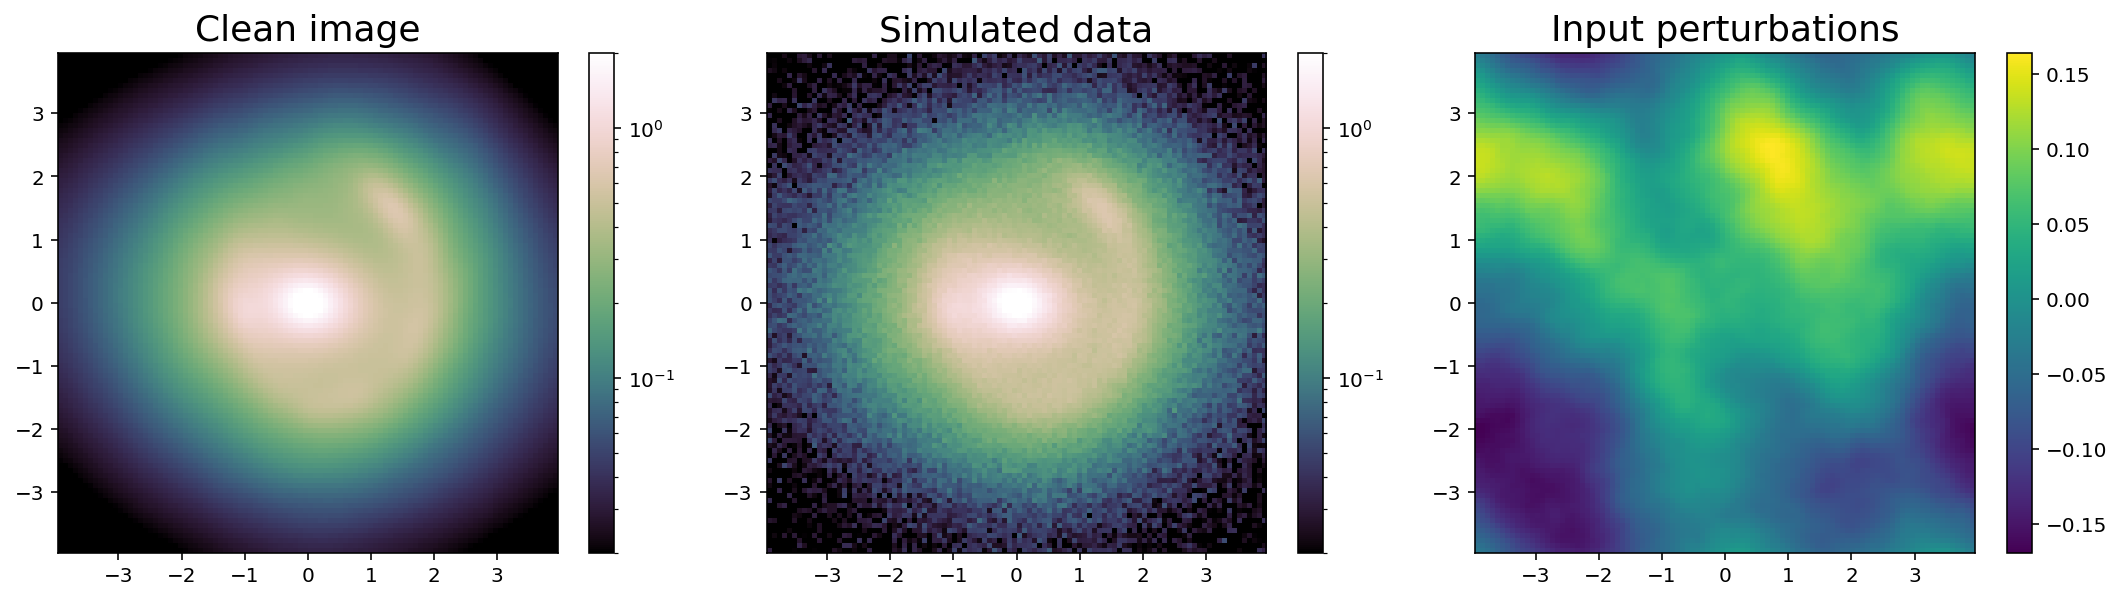

In [8]:
# Generate a lensed image based on source and lens models
clean_image = lens_image_input.model(kwargs_lens=kwargs_lens_input,
                              kwargs_source=kwargs_source_input,
                              kwargs_lens_light=kwargs_lens_light_input)

# Observed noisy data
data = lens_image_input.simulation(kwargs_lens=kwargs_lens_input,
                                   kwargs_source=kwargs_source_input,
                                   kwargs_lens_light=kwargs_lens_light_input,
                                   noise_seed=18)

# here we assume that the noise is perefectly known
#lens_image_fit.Noise.set_data(clean_image)
lens_image_fit.Noise.compute_noise_map_from_model(clean_image, as_jax_array=False)

# get the true source surface brightness
source_input = lens_image_input.source_surface_brightness(kwargs_source_input,
                                                          de_lensed=True, unconvolved=True)
source_input_lensed = lens_image_input.source_surface_brightness(kwargs_source_input, kwargs_lens=kwargs_lens_input,
                                                                 de_lensed=False, unconvolved=False)

# inform the plotter for later
plotter.set_data(data)
plotter.set_ref_source(source_input)
plotter.set_ref_pixelated_potential(psi_grid_input_fitgrid)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("Clean image", fontsize=18)
im = ax.imshow(clean_image, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("Simulated data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("Input perturbations", fontsize=18)
im = ax.imshow(psi_grid_input, origin='lower', extent=extent, cmap=plotter.cmap_default)
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

## Model fitting

### Prepare the parameters (initial values, constraints, etc.)

In [9]:
# no perturbations for first fit (small number)
psi_grid_init = 1e-8 * np.ones_like(psi_grid_input_fitgrid)


kwargs_input = {
    'kwargs_lens': [kwargs_lens_input[0], kwargs_lens_input[1], {'pixels': psi_grid_init}],
    'kwargs_source': kwargs_source_input,
    'kwargs_lens_light': [{}],
}
kwargs_init = deepcopy(kwargs_input)
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0.0, 'dec_0': 0.}, {'pixels': psi_grid_init}], 
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_lens_light_input,  # lens light is fixed
}
kwargs_joint = {
    # fix lens center to lens light center
    'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
}
parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed, 
                        kwargs_joint=kwargs_joint, kwargs_prior=None)
print("Number of fitted parameters:", parameters.num_parameters)

source_num_params = len([1 for i in range(len(kwargs_source_input)) for _ in kwargs_source_input[i].values()])

Number of fitted parameters: 12


### Fit source and macro lens model (if required)

In [10]:
if fit_fully_smooth_first is True:
    # Create loss
    loss_smooth_fit = Loss(data, lens_image_fit, parameters, 
                                likelihood_type='chi2', prior_terms=None)
    print("Initial loss:", loss_smooth_fit(parameters.kwargs2args(kwargs_init)))
    print("Number of data points in likelihood:", loss_smooth_fit.likelihood_num_data_points)

    # Optimizer
    optimizer_smooth_fit = Optimizer(loss_smooth_fit, parameters)
    best_fit, logL, extra_fields, runtime \
        = optimizer_smooth_fit.minimize(method='BFGS', restart_from_init=True,
                             use_exact_hessian_if_allowed=False)
    print(f"Runtime: {runtime}")
    print("Loss at best-fit:", loss_smooth_fit(best_fit))
    kwargs_smooth_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

    fig = plotter.model_summary(lens_image_fit, kwargs_smooth_fit, show_source=False)
    
    if SAVE_FIGURES:
        fig_name = f'wavelet_pot-smooth_src-input_{perturbation_type}_smooth-fit.pdf'
        fig_path = os.path.join('figures', 'smooth fits', fig_name)
        fig.savefig(fig_path, dpi=100, bbox_inches='tight')

else:
    kwargs_smooth_fit = {
        'kwargs_lens': [kwargs_lens_input[0], {'pixels': psi_grid_init}],
        'kwargs_source': kwargs_source_input,
        'kwargs_lens_light': kwargs_lens_light_input,
    }

### Add pixelated perturbations to the potential

In [11]:
# unfix everything (except shear origin)
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}, {}],
    'kwargs_source': [{}],
}
parameters.update_fixed(kwargs_fixed)
print("Number of fitted parameters:", parameters.num_parameters)
#print(parameters.initial_values(as_kwargs=True))

Number of fitted parameters: 637


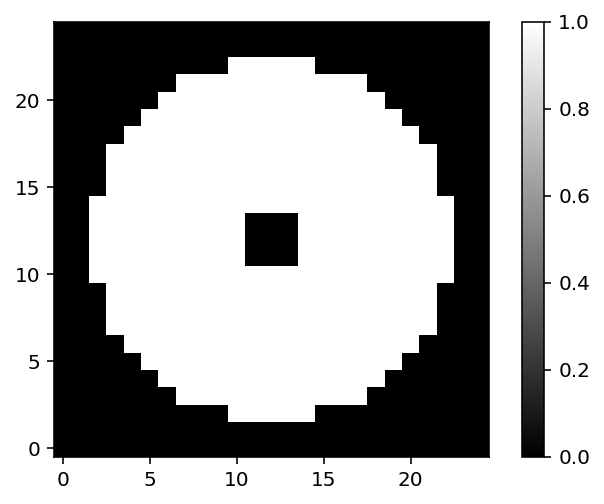

In [12]:
# Generate a mask
rmin = 0.5
rmax = 3.3
# Low-res grid
radius_fit = np.hypot(x_grid_fit, y_grid_fit)
mask_fit = ((radius_fit >= rmin) & (radius_fit <= rmax)).astype(float)

plt.figure()
plt.imshow(mask_fit, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

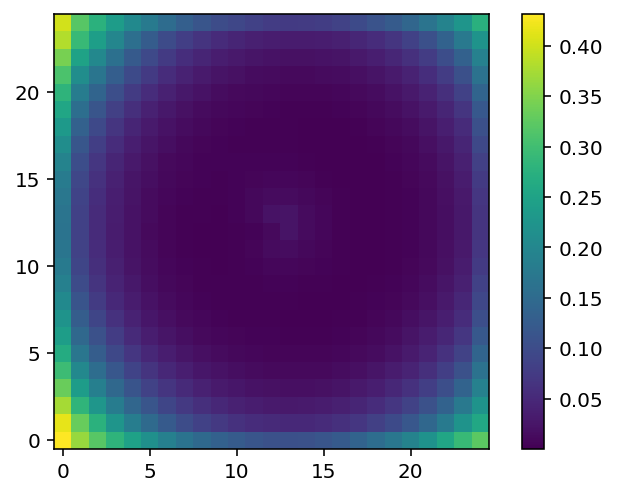

0.012835090361445787


In [13]:
# Choose noise map for potential grid regularization
npix_pixpot = len(x_grid_fit)
noise_map_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/notebooks/data'
file_name = f'dpsi_1sigma_bkg{sigma_bkd}_{npix_pixpot}px_fullmass_fullamp.npy'
potential_noise_map = np.load(os.path.join(noise_map_dir, file_name))


plt.figure()
plt.imshow(potential_noise_map, origin='lower')
plt.colorbar()
plt.show()


# TEST: take the mean within the mask
#potential_noise_map = np.mean(potential_noise_map[mask_fit == 1.])

print(np.mean(potential_noise_map[mask_fit == 1.]))

In [14]:
# Create loss
if not wavelet_regularization:
    loss_pixpot_fit = Loss(data, lens_image_fit, parameters, 
                           likelihood_type='l2_norm', 
                           regularization_terms=None,
                           prior_terms=None)
else:
    loss_pixpot_fit = Loss(data, lens_image_fit, parameters, 
                           likelihood_type='l2_norm', 
                           #regularization_terms=None,
                           regularization_terms=['l1_starlet_potential', 'l1_battle_potential'], 
                           regularization_strengths=[(3, 3), 10],
                           potential_noise_map=potential_noise_map,
                           prior_terms=None)
print("Number of data points in likelihood:", loss_pixpot_fit.likelihood_num_data_points)

Number of data points in likelihood: 10000


In [15]:
optimizer_pixpot_fit = Optimizer(loss_pixpot_fit, parameters)
optimizer_type = 'optax'

if optimizer_type == 'minimize':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit.minimize(method='trust-krylov', maxiter=None, 
                                        restart_from_init=(not start_from_fully_smooth))
elif optimizer_type == 'optax':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit.optax(max_iterations=800, 
                                     init_learning_rate=1e-3,
                                     restart_from_init=(not start_from_fully_smooth))

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_pixpot_fit(best_fit))

kwargs_pixpot_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

optax.adabelief: 100%|██████████| 800/800 [00:33<00:00, 23.96it/s]


Runtime: 33.390697956085205
Loss at best-fit: 1.1019682


In [16]:
if optimizer_type == 'minimize':
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(len(optimizer_pixpot_fit.loss_history)), optimizer_pixpot_fit.loss_history)
    ax.set_ylabel("Loss", fontsize=18)
    ax.set_xlabel("Iteration", fontsize=18)
    plt.show()

delta_psi shift by mean values: -0.00019318453 0.026404817


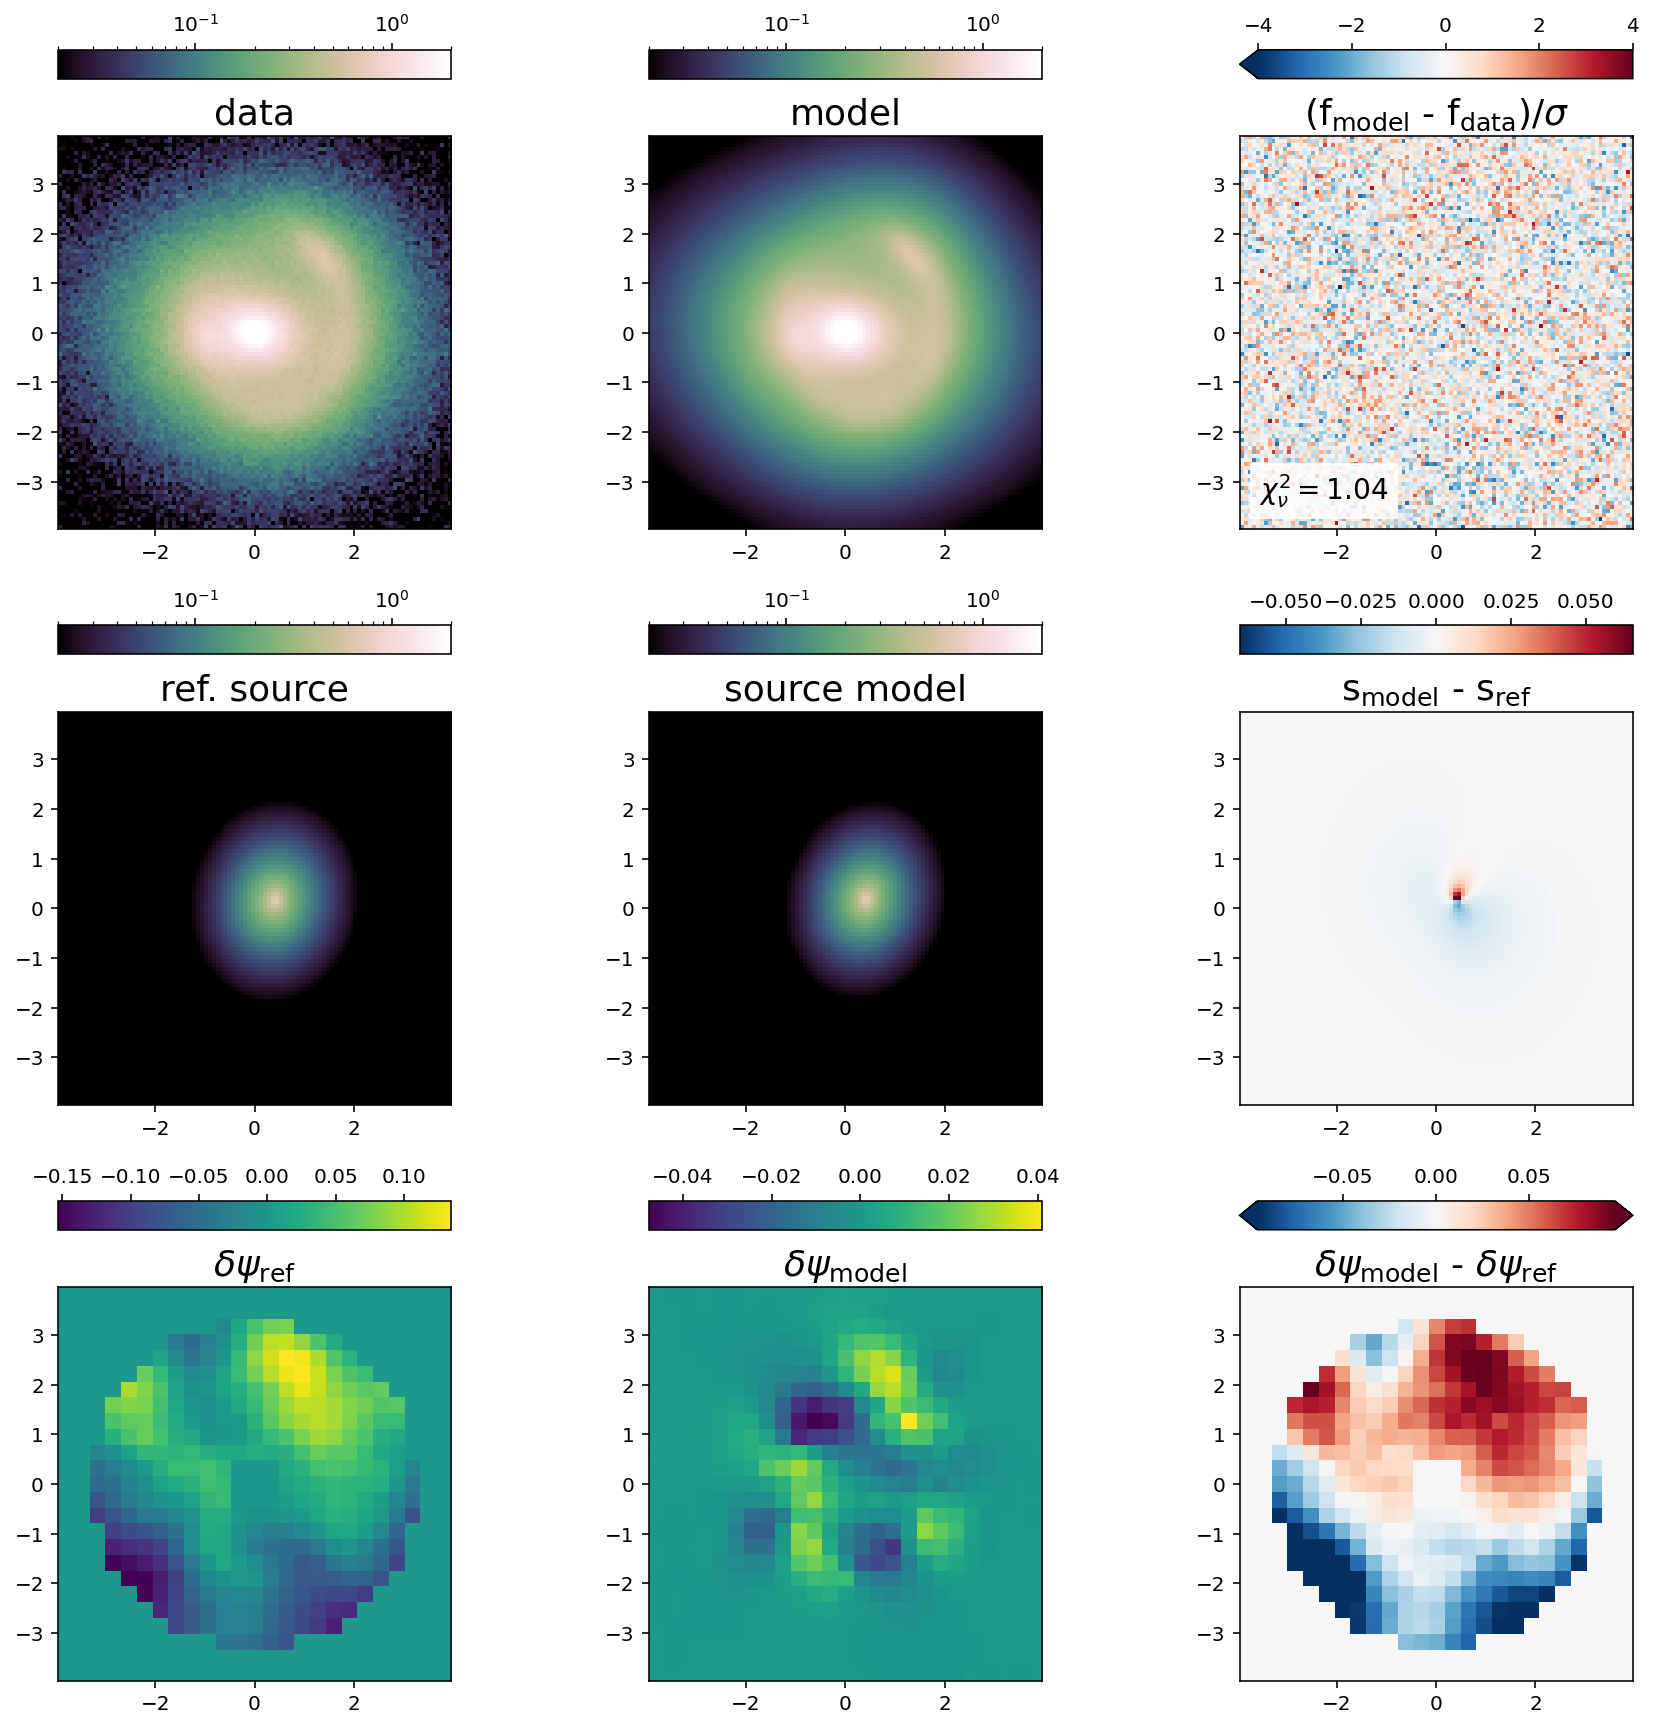

In [17]:
shift_pixelated_potential = 'mean'
fig = plotter.model_summary(lens_image_fit, kwargs_pixpot_fit,
                            show_lens_potential=True, potential_mask=mask_fit,
                            shift_pixelated_potential=shift_pixelated_potential,
                            #vmin_pot=-0.1, vmax_pot=0.1,
                            )

In [18]:
# save the figure
if SAVE_FIGURES:
    fig_name = f'wavelet_pot-smooth_src-input_{perturbation_type}_full-fit'
    if not wavelet_regularization:
        fig_name += '_no-reg'
    fig_path = os.path.join('figures', 'full fits', fig_name + '.pdf')
    fig.savefig(fig_path, dpi=100, bbox_inches='tight')

#### Save fisher matrix and reconstructed potential for further analysis

In [19]:
# compute or retrieve the inverse of the Hessian matrix
if 'hess_inv' in extra_fields:
    print("Using approximated inverse Hessian")
    full_fisher_matrix = extra_fields['hess_inv']
else:
    start = time.time()
    full_hessian_best_fit = optimizer_pixpot_fit.hessian(best_fit)
    full_fisher_matrix = jnp.linalg.inv(full_hessian_best_fit).block_until_ready()
    print("Time to compute the inverse Hessian matrix:", time.time()-start)
    full_fisher_matrix = np.array(full_fisher_matrix)

Time to compute the inverse Hessian matrix: 26.279383182525635


In [26]:
# here we modify the Parameters such that
# only the source parameters are not fixed
# in order to retrieve an alternative covariance matrix
kwargs_fixed_src = {
    'kwargs_lens': kwargs_pixpot_fit['kwargs_lens'],
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_pixpot_fit['kwargs_lens_light'],
}
parameters_src = deepcopy(parameters)
parameters_src.update_fixed(kwargs_fixed_src)
print(parameters_src.num_parameters)
loss_src = Loss(data, lens_image_fit, parameters_src, 
                likelihood_type='chi2')
optimizer_src = Optimizer(loss_src, parameters_src)
src_hessian_best_fit = optimizer_src.hessian(best_fit[-source_num_params:])
src_fisher_matrix = jnp.linalg.inv(src_hessian_best_fit).block_until_ready()

7


In [27]:
print(full_fisher_matrix.shape)
# retrieve true and pixelated source and potential images
if SAVE_MODELS:
    base_filename = f'-{perturbation_type}-scale_{potential_pixel_scale}-smooth_source'

    hdr_fisher = fits.Header()
    hdr_fisher['SRCIDX1'] = (len(full_fisher_matrix) - source_num_params, 'starting index for source parameters')
    hdr_fisher['SRCIDX2'] = (len(full_fisher_matrix), 'ending index for source parameters')
    col1 = fits.Column(name='symbols', format='20A', array=parameters.symbols)
    col2 = fits.Column(name='bestfit', format='E', array=np.array(parameters.current_values()))
    col3 = fits.Column(name='input', format='E', array=np.array(parameters.kwargs2args(kwargs_input)))
    hdus = fits.HDUList([
        fits.PrimaryHDU(full_fisher_matrix, header=hdr_fisher),
        fits.ImageHDU(src_fisher_matrix),
        fits.BinTableHDU.from_columns([col1, col2, col3]),
    ])
    hdus.writeto(os.path.join('results', 'fisher'+base_filename+'.fits'), overwrite=True)
    
    hdr_psi = fits.Header()
    hdr_psi['PIXSCALE'] = (potential_pixel_scale, 'pixel scale factor for pixelated potential grid')
    psi_grid_model = kwargs_pixpot_fit['kwargs_lens'][-1]['pixels']
    hdus = fits.HDUList([
        fits.PrimaryHDU(psi_grid_model, header=hdr_psi), 
        fits.ImageHDU(psi_grid_input, header=hdr_psi),
        fits.ImageHDU(psi_grid_input_fitgrid),
        fits.ImageHDU(mask_fit, header=hdr_psi),
    ])
    hdus.writeto(os.path.join('results', 'pixpot'+base_filename+'.fits'), overwrite=True)

(637, 637)


## Estimate the variance map of the potential

## Comparison of critical curves